In [22]:
%reset -f
import time
import os
import gzip
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn import preprocessing

In [23]:
def load_mnist(path, kind='train'):


    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

In [24]:
def _filter(xs, ys, lbls):
    idxs = [i for (i, l) in enumerate(ys) if l in lbls]
    return xs[idxs, :], ys[idxs]

In [25]:
def clear_gpu(model):
    # Removes model from gpu and clears the memory
    
    model = model.to('cpu')
    del model
    torch.cuda.empty_cache()

In [26]:
class Dataset(torch.utils.data.Dataset):
    # Basic dataset class to work with torch data loader

    def __init__(self, X, y):
        self.X = X
        self.y = y
        
        assert len(X) == len(y), print("Number of examples don't match up")

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [27]:
class FashionNet(torch.nn.Module):
    def __init__(self):
        super(FashionNet, self).__init__()
        
        self.inp_drop = torch.nn.Dropout(0)
        self.conv_drop = torch.nn.Dropout(0.25)
        self.fc_drop = torch.nn.Dropout(0.25)
        
        self.pool = torch.nn.MaxPool2d(2, 2)
        
        self.conv1 = torch.nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = torch.nn.Conv2d(6, 16, 5)
        
        self.fc1 = torch.nn.Linear(16 * 4 * 4, 240)
        self.fc2 = torch.nn.Linear(240, 168)
        self.fc3 = torch.nn.Linear(168, 5)

    def forward(self, x):
        x = self.inp_drop(x)
        
        x = self.pool(F.relu(self.conv1(x)))
        x = self.conv_drop(x)

        x = self.pool(F.relu(self.conv2(x)))
        x = self.conv_drop(x)

        x = x.view(-1, 16 * 4 * 4)
        x = self.fc_drop(x)

        x = F.relu(self.fc1(x))
        x = self.fc_drop(x)

        x = F.relu(self.fc2(x))
        x = self.fc_drop(x)

        x = self.fc3(x) 
        
        return x

In [28]:
def predict(X, y, model, loss_fn):
    
    model.eval()
    
    with torch.no_grad():
        out = model.forward(X)
        preds = out.argmax(axis=1)

        acc = sum(preds == y)/len(y)
        loss = loss_fn(out, y)
        
    model.train()
    
    return acc, loss

In [29]:
def train(train_generator, X_train, y_train, X_val, y_val, model, max_epoch, loss_fn, optimizer, path):
    history = {
    'acc': [],
    'loss': [],
    'val_acc': [],
    'val_loss': []
    }
    
    best_loss = np.inf
    best_epoch = 0
    for epoch in tqdm(range(max_epoch)):
        for i, data in enumerate(train_generator):
            inputs, labels = data
            inputs = inputs.type(torch.FloatTensor).to(device)
            labels =  labels.type(torch.LongTensor).to(device)

            optimizer.zero_grad()

            outputs = model.forward(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
    
        acc, loss = predict(X_train, y_train, model, loss_fn)  
        history['acc'].append(acc.item())
        history['loss'].append(loss.item())
        
        acc, loss = predict(X_val, y_val, model, loss_fn)
        history['val_acc'].append(acc.item())
        history['val_loss'].append(loss.item())

        if loss < best_loss:
            best_epoch = epoch
            torch.save(model.state_dict(), path)
            
    return history

In [30]:
dataloader_params = {'batch_size': 32, 'shuffle': True, 'num_workers': 6}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load Data

In [31]:
train_images, train_labels = load_mnist('../data', 'train')
test_images, test_labels = load_mnist('../data', 't10k')

val_images = train_images[50000:]
val_labels = train_labels[50000:]

train_images = train_images[:50000]
train_labels = train_labels[:50000]

In [32]:
X_train1, y_train1 = _filter(train_images, train_labels, [0, 1, 4, 5, 8])
X_val1, y_val1 = _filter(val_images, val_labels, [0, 1, 4, 5, 8])
X_test1, y_test1 = _filter(test_images, test_labels, [0, 1, 4, 5, 8])

In [33]:
X_train2, y_train2 = _filter(train_images, train_labels, [2, 3, 6, 7, 9])
X_val2, y_val2 = _filter(val_images, val_labels, [2, 3, 6, 7, 9])
X_test2, y_test2 = _filter(test_images, test_labels, [2, 3, 6, 7, 9])

# FMNIST 2 Training

In [34]:
X_train2 = X_train2.reshape(X_train2.shape[0], 28, 28)
X_test2 = X_test2.reshape(X_test2.shape[0], 28, 28)
X_val2 = X_val2.reshape(X_val2.shape[0], 28, 28)

In [35]:
X_train2 = X_train2[:, np.newaxis, :, :]
X_test2 = X_test2[:, np.newaxis, :, :]
X_val2 = X_val2[:, np.newaxis, :, :]

In [36]:
le2 = preprocessing.LabelEncoder()
le2.fit(y_train2)
y_train2 = le2.transform(y_train2)
y_val2 = le2.transform(y_val2)
y_test2 = le2.transform(y_test2)

In [37]:
train_data2 = Dataset(X_train2, y_train2)
train_generator2 = torch.utils.data.DataLoader(train_data2, **dataloader_params)

X_train2 = torch.from_numpy(X_train2).type(torch.FloatTensor).to(device)
y_train2 = torch.Tensor(y_train2).type(torch.LongTensor).to(device)

X_val2 = torch.from_numpy(X_val2).type(torch.FloatTensor).to(device)
y_val2 = torch.Tensor(y_val2).type(torch.LongTensor).to(device)

X_test2 = torch.from_numpy(X_test2).type(torch.FloatTensor).to(device)
y_test2 = torch.Tensor(y_test2).type(torch.LongTensor).to(device)

In [38]:
net = FashionNet().to(device)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters())
#optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.7)

In [39]:
num = 1
path = 'models/checkpoints/3.4_tuning_{}'.format(num)

history = train(train_generator2, X_train2, y_train2, X_val2, y_val2, net, 100, loss_fn, optimizer, path)

net.load_state_dict(torch.load(path))
acc, loss = predict(X_test2, y_test2, net, loss_fn)
print(acc, loss)
clear_gpu(net)

100%|██████████| 100/100 [05:22<00:00,  3.23s/it]


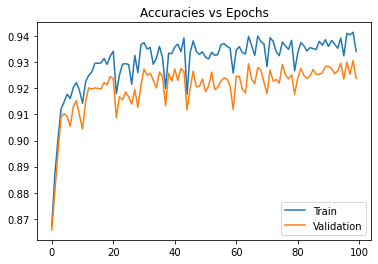

In [40]:
plt.plot(history['acc'])
plt.plot(history['val_acc'])
plt.title("Accuracies vs Epochs")
plt.legend(['Train', 'Validation'])
plt.show()

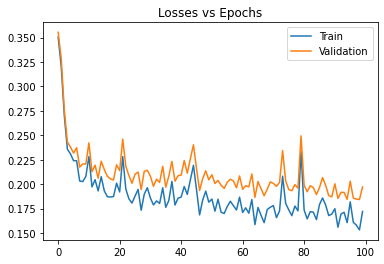

In [41]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title("Losses vs Epochs")
plt.legend(['Train', 'Validation'])
plt.show()

# Fashion MNIST 1 Random Training

In [69]:
X_train1 = X_train1.reshape(X_train1.shape[0], 28, 28)
X_test1 = X_test1.reshape(X_test1.shape[0], 28, 28)
X_val1 = X_val1.reshape(X_val1.shape[0], 28, 28)

In [70]:
X_train1 = X_train1[:, np.newaxis, :, :]
X_test1 = X_test1[:, np.newaxis, :, :]
X_val1 = X_val1[:, np.newaxis, :, :]

In [71]:
le1 = preprocessing.LabelEncoder()
le1.fit(y_train1)
y_train1 = le1.transform(y_train1)
y_val1 = le1.transform(y_val1)
y_test1 = le1.transform(y_test1)

In [72]:
X_train1 = torch.from_numpy(X_train1).type(torch.FloatTensor)
y_train1 = torch.Tensor(y_train1).type(torch.LongTensor)

X_val1 = torch.from_numpy(X_val1).type(torch.FloatTensor).to(device)
y_val1 = torch.Tensor(y_val1).type(torch.LongTensor).to(device)

X_test1 = torch.from_numpy(X_test1).type(torch.FloatTensor).to(device)
y_test1 = torch.Tensor(y_test1).type(torch.LongTensor).to(device)

In [17]:
type = 'random'


train_losses = []
train_accuracies = []

test_losses = []
test_accuracies = []

val_losses = []
val_accuracies = []

max_epochs = 100

for i in range(1, 21):

    ratio = 5 * i
    size = int(ratio * len(X_train1)/100)
    path = 'models/checkpoints/3.4_{}_{}'.format(type, ratio)

    net = FashionNet().to(device)
    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())

    train_data1 = Dataset(X_train1[:size], y_train1[:size])
    train_generator1 = torch.utils.data.DataLoader(train_data1, **dataloader_params)

    train(train_generator1, X_train1[:size].to(device), y_train1[:size].to(device), 
          X_val1, y_val1, net, max_epochs, loss_fn, optimizer, path)

    net.load_state_dict(torch.load(path))
    
    acc, loss = predict(X_test1, y_test1, net, loss_fn)
    test_accuracies.append(acc.item())
    test_losses.append(loss.item())
       
    acc, loss = predict(X_train1[:size].to(device), y_train1[:size].to(device), net, loss_fn)
    train_accuracies.append(acc.item())
    train_losses.append(loss.item())
    
    acc, loss = predict(X_val1, y_val1, net, loss_fn)
    val_accuracies.append(acc.item())
    val_losses.append(loss.item())
    
    clear_gpu(net)

100%|██████████| 10/10 [00:04<00:00,  2.23it/s]


In [20]:
np.save('random_train_accuracies', train_accuracies)
np.save('random_test_accuracies', test_accuracies)
np.save('random_val_accuracies', val_accuracies)

# Fashion MNIST 1 Pretrained Training

In [169]:
path = 'models/checkpoints/3.4_tuning_1'.format(num)
state_dict = torch.load(path)

In [170]:
type = 'pretrained'

train_losses = []
train_accuracies = []

test_losses = []
test_accuracies = []

val_losses = []
val_accuracies = []

max_epochs = 100

for i in range(1, 3):

    ratio = 5 * i
    size = int(ratio * len(X_train1)/100)
    path = 'models/checkpoints/3.4_{}_{}'.format(type, ratio)

    net = FashionNet().to(device)
    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())

    state_dict['fc3.weight'] = net.fc3.weight.data
    state_dict['fc3.bias'] = net.fc3.bias.data
    net.load_state_dict(state_dict)

    train_data1 = Dataset(X_train1[:size], y_train1[:size])
    train_generator1 = torch.utils.data.DataLoader(train_data1, **dataloader_params)

    train(train_generator1, X_train1[:size].to(device), y_train1[:size].to(device), 
          X_val1, y_val1, net, max_epochs, loss_fn, optimizer, path)

    net.load_state_dict(torch.load(path))
    
    acc, loss = predict(X_test1, y_test1, net, loss_fn)
    test_accuracies.append(acc.item())
    test_losses.append(loss.item())
       
    acc, loss = predict(X_train1[:size].to(device), y_train1[:size].to(device), net, loss_fn)
    train_accuracies.append(acc.item())
    train_losses.append(loss.item())
    
    acc, loss = predict(X_val1, y_val1, net, loss_fn)
    val_accuracies.append(acc.item())
    val_losses.append(loss.item())
    
    clear_gpu(net)

100%|██████████| 100/100 [00:45<00:00,  2.20it/s]


In [171]:
np.save('pretrained_train_accuracies', train_accuracies)
np.save('pretrained_test_accuracies', test_accuracies)
np.save('pretrained_val_accuracies', val_accuracies)

In [172]:
np.save('pretrained_train_losses', train_losses)
np.save('pretrained_test_losses', test_losses)
np.save('pretrained_val_losses', val_losses)

# Comparison

In [178]:
random_training_accuracies = np.load('random_train_accuracies.npy')
random_val_accuracies = np.load('random_val_accuracies.npy')

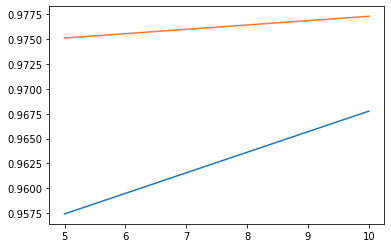

In [182]:
plt.plot([5, 10], random_val_accuracies)
plt.plot([5, 10], val_accuracies)